In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
transforms = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
        './data',
        train=True,
        download=True,
        transform=transforms)

test_dataset = datasets.MNIST(
        './data',
        train=False,
        download=True,
        transform=transforms
    )

In [3]:
train_data_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=1000)

In [4]:
train_data_loader.batch_size

1000

In [5]:
# Building the encoder separately
class BasicBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BasicBlock, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.transform = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                       nn.Tanh(),
                                       nn.Linear(hidden_dim, hidden_dim),
                                       nn.Tanh())
        self.fc_mu = nn.Linear(hidden_dim, output_dim)
        self.fc_logsigma = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = self.transform(x)
        mu = self.fc_mu(out)
        logsigma = self.fc_logsigma(out)
        sigma = torch.exp(logsigma)
        return mu, sigma

In [6]:
# Removing data from train set
def removeProbData(tensorOG, p):
    image =tensorOG.numpy()
    nump = np.random.rand(image.shape[0],image.shape[1])
    mask = (nump<(1-p))*1.0
    img_removed = mask*image
    
    return torch.from_numpy(mask), torch.from_numpy(img_removed)

In [7]:
# Model
class MIWAE(nn.Module):
    def __init__(self, dim_h1, dim_image_vars):
        super(MIWAE, self).__init__()
        self.dim_h1 = dim_h1
        self.dim_image_vars = dim_image_vars

        ## encoder
        self.encoder_h1 = BasicBlock(dim_image_vars, 200, dim_h1)
        
        ## decoder
        self.decoder_x =  nn.Sequential(nn.Linear(dim_h1, 200),
                                        nn.Tanh(),
                                        nn.Linear(200, 200),
                                        nn.Tanh(),
                                        nn.Linear(200, dim_image_vars),
                                        nn.Sigmoid())
        
    def encoder(self, x):
        mu_h1, sigma_h1 = self.encoder_h1(x)
        eps = Variable(sigma_h1.data.new(sigma_h1.size()).normal_())
        h1 = mu_h1 + sigma_h1 * eps   
        return h1, mu_h1, sigma_h1, eps
    
    def decoder(self, h1):
        p = self.decoder_x(h1)

        return p
    
    def forward(self, x):
        h1, mu_h1, sigma_h1, eps = self.encoder(x)
        p = self.decoder(h1)
        return (h1, mu_h1, sigma_h1, eps), (p)

    def train_loss(self, inputs):
        h1, mu_h1, sigma_h1, eps = self.encoder(inputs)
        log_Qh1Gx = torch.sum(-0.5*(eps)**2 - torch.log(sigma_h1), -1)
        
        p = self.decoder(h1)
        log_Ph1 = torch.sum(-0.5*h1**2, -1)
        log_PxGh1 = torch.sum(inputs*torch.log(p) + (1-inputs)*torch.log(1-p), -1)

        log_weight = log_Ph1 + log_PxGh1 - log_Qh1Gx
        log_weight = log_weight - torch.max(log_weight, 0)[0]
        weight = torch.exp(log_weight)
        weight = weight / torch.sum(weight, 0)
        weight = Variable(weight.data, requires_grad = False)
        loss = -torch.mean(torch.sum(weight * (log_Ph1 + log_PxGh1 - log_Qh1Gx), 0))

        return loss

    
    def impute(self, inputs):
        inputs1 = inputs
        h1, mu_h1, sigma_h1, eps = self.encoder(inputs1)
        #log_Qh1Gx = torch.sum(-0.5*((h1-mu_h1)/sigma_h1)**2 - torch.log(sigma_h1), -1)
        log_Qh1Gx = torch.sum(-0.5*(eps)**2 - torch.log(sigma_h1), -1)
        
        p = self.decoder(h1)
        print(p.shape)
        log_Ph1 = torch.sum(-0.5*h1**2, -1)
        log_PxGh1 = torch.sum(inputs1*torch.log(p) + (1-inputs1)*torch.log(1-p), -1)

        log_weight = log_Ph1 + log_PxGh1 - log_Qh1Gx
        log_weight = log_weight - torch.max(log_weight, 0)[0]
        
        weight = torch.exp(log_weight)
        weight = weight / torch.sum(weight, 0)
        print(weight.shape)
        #weight = Variable(weight.data, requires_grad = False)
        weight.unsqueeze_(-1)
        weight = weight.expand(5,784)
        print(weight.shape)
        img = torch.mean(weight * (p), 0)

        return img

In [8]:
vae = MIWAE(50, 784)
vae.double()

MIWAE(
  (encoder_h1): BasicBlock(
    (transform): Sequential(
      (0): Linear(in_features=784, out_features=200, bias=True)
      (1): Tanh()
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): Tanh()
    )
    (fc_mu): Linear(in_features=200, out_features=50, bias=True)
    (fc_logsigma): Linear(in_features=200, out_features=50, bias=True)
  )
  (decoder_x): Sequential(
    (0): Linear(in_features=50, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [12]:
# Training on Incomplete Data
vae.double()
prob = 0.3
optimizer = optim.Adam(vae.parameters())
num_epoches = 20
train_loss_epoch = []
for epoch in range(num_epoches):
    running_loss = [] 
    for idx, data in enumerate(train_data_loader):
        inputs = Variable(data[0])
        print(type(inputs))
        
        inputs = inputs.view(-1, 28 * 28)
        mask, inputs = removeProbData(inputs, prob)
        inputs = inputs.expand(5, 1000, 784)
        
        optimizer.zero_grad()
        loss = vae.train_loss(inputs)
        loss.backward()
        optimizer.step()    
        print(("Epoch: {:>4}, Step: {:>4}, loss: {:>4.2f}")
              .format(epoch, idx, loss.item()), flush = True)
        running_loss.append(loss.item())
    train_loss_epoch.append(np.mean(np.sum(running_loss)))

<class 'torch.Tensor'>
Epoch:    0, Step:    0, loss: 120.63
<class 'torch.Tensor'>
Epoch:    0, Step:    1, loss: 122.75
<class 'torch.Tensor'>
Epoch:    0, Step:    2, loss: 119.49
<class 'torch.Tensor'>
Epoch:    0, Step:    3, loss: 123.44
<class 'torch.Tensor'>
Epoch:    0, Step:    4, loss: 121.96
<class 'torch.Tensor'>
Epoch:    0, Step:    5, loss: 120.88
<class 'torch.Tensor'>
Epoch:    0, Step:    6, loss: 120.04
<class 'torch.Tensor'>
Epoch:    0, Step:    7, loss: 122.19
<class 'torch.Tensor'>
Epoch:    0, Step:    8, loss: 122.72
<class 'torch.Tensor'>
Epoch:    0, Step:    9, loss: 121.41
<class 'torch.Tensor'>
Epoch:    0, Step:   10, loss: 120.01
<class 'torch.Tensor'>
Epoch:    0, Step:   11, loss: 120.30
<class 'torch.Tensor'>
Epoch:    0, Step:   12, loss: 121.79
<class 'torch.Tensor'>
Epoch:    0, Step:   13, loss: 121.30
<class 'torch.Tensor'>
Epoch:    0, Step:   14, loss: 119.72
<class 'torch.Tensor'>
Epoch:    0, Step:   15, loss: 121.65
<class 'torch.Tensor'>
E

<class 'torch.Tensor'>
Epoch:    2, Step:   15, loss: 120.69
<class 'torch.Tensor'>
Epoch:    2, Step:   16, loss: 118.30
<class 'torch.Tensor'>
Epoch:    2, Step:   17, loss: 119.60
<class 'torch.Tensor'>
Epoch:    2, Step:   18, loss: 119.73
<class 'torch.Tensor'>
Epoch:    2, Step:   19, loss: 119.77
<class 'torch.Tensor'>
Epoch:    2, Step:   20, loss: 119.80
<class 'torch.Tensor'>
Epoch:    2, Step:   21, loss: 119.87
<class 'torch.Tensor'>
Epoch:    2, Step:   22, loss: 118.15
<class 'torch.Tensor'>
Epoch:    2, Step:   23, loss: 122.49
<class 'torch.Tensor'>
Epoch:    2, Step:   24, loss: 120.12
<class 'torch.Tensor'>
Epoch:    2, Step:   25, loss: 121.16
<class 'torch.Tensor'>
Epoch:    2, Step:   26, loss: 119.48
<class 'torch.Tensor'>
Epoch:    2, Step:   27, loss: 121.17
<class 'torch.Tensor'>
Epoch:    2, Step:   28, loss: 120.29
<class 'torch.Tensor'>
Epoch:    2, Step:   29, loss: 120.33
<class 'torch.Tensor'>
Epoch:    2, Step:   30, loss: 120.18
<class 'torch.Tensor'>
E

<class 'torch.Tensor'>
Epoch:    4, Step:   30, loss: 120.03
<class 'torch.Tensor'>
Epoch:    4, Step:   31, loss: 119.08
<class 'torch.Tensor'>
Epoch:    4, Step:   32, loss: 120.70
<class 'torch.Tensor'>
Epoch:    4, Step:   33, loss: 118.46
<class 'torch.Tensor'>
Epoch:    4, Step:   34, loss: 119.84
<class 'torch.Tensor'>
Epoch:    4, Step:   35, loss: 120.39
<class 'torch.Tensor'>
Epoch:    4, Step:   36, loss: 118.62
<class 'torch.Tensor'>
Epoch:    4, Step:   37, loss: 119.05
<class 'torch.Tensor'>
Epoch:    4, Step:   38, loss: 119.16
<class 'torch.Tensor'>
Epoch:    4, Step:   39, loss: 118.10
<class 'torch.Tensor'>
Epoch:    4, Step:   40, loss: 119.90
<class 'torch.Tensor'>
Epoch:    4, Step:   41, loss: 119.96
<class 'torch.Tensor'>
Epoch:    4, Step:   42, loss: 120.37
<class 'torch.Tensor'>
Epoch:    4, Step:   43, loss: 119.63
<class 'torch.Tensor'>
Epoch:    4, Step:   44, loss: 119.83
<class 'torch.Tensor'>
Epoch:    4, Step:   45, loss: 120.93
<class 'torch.Tensor'>
E

<class 'torch.Tensor'>
Epoch:    6, Step:   45, loss: 118.56
<class 'torch.Tensor'>
Epoch:    6, Step:   46, loss: 118.75
<class 'torch.Tensor'>
Epoch:    6, Step:   47, loss: 120.74
<class 'torch.Tensor'>
Epoch:    6, Step:   48, loss: 117.05
<class 'torch.Tensor'>
Epoch:    6, Step:   49, loss: 120.40
<class 'torch.Tensor'>
Epoch:    6, Step:   50, loss: 118.15
<class 'torch.Tensor'>
Epoch:    6, Step:   51, loss: 120.49
<class 'torch.Tensor'>
Epoch:    6, Step:   52, loss: 119.34
<class 'torch.Tensor'>
Epoch:    6, Step:   53, loss: 118.13
<class 'torch.Tensor'>
Epoch:    6, Step:   54, loss: 120.96
<class 'torch.Tensor'>
Epoch:    6, Step:   55, loss: 120.31
<class 'torch.Tensor'>
Epoch:    6, Step:   56, loss: 119.70
<class 'torch.Tensor'>
Epoch:    6, Step:   57, loss: 120.94
<class 'torch.Tensor'>
Epoch:    6, Step:   58, loss: 119.60
<class 'torch.Tensor'>
Epoch:    6, Step:   59, loss: 118.06
<class 'torch.Tensor'>
Epoch:    7, Step:    0, loss: 118.25
<class 'torch.Tensor'>
E

<class 'torch.Tensor'>
Epoch:    9, Step:    0, loss: 119.80
<class 'torch.Tensor'>
Epoch:    9, Step:    1, loss: 120.32
<class 'torch.Tensor'>
Epoch:    9, Step:    2, loss: 120.24
<class 'torch.Tensor'>
Epoch:    9, Step:    3, loss: 121.02
<class 'torch.Tensor'>
Epoch:    9, Step:    4, loss: 119.18
<class 'torch.Tensor'>
Epoch:    9, Step:    5, loss: 116.89
<class 'torch.Tensor'>
Epoch:    9, Step:    6, loss: 119.23
<class 'torch.Tensor'>
Epoch:    9, Step:    7, loss: 118.54
<class 'torch.Tensor'>
Epoch:    9, Step:    8, loss: 118.90
<class 'torch.Tensor'>
Epoch:    9, Step:    9, loss: 120.78
<class 'torch.Tensor'>
Epoch:    9, Step:   10, loss: 119.68
<class 'torch.Tensor'>
Epoch:    9, Step:   11, loss: 119.34
<class 'torch.Tensor'>
Epoch:    9, Step:   12, loss: 119.64
<class 'torch.Tensor'>
Epoch:    9, Step:   13, loss: 118.57
<class 'torch.Tensor'>
Epoch:    9, Step:   14, loss: 120.50
<class 'torch.Tensor'>
Epoch:    9, Step:   15, loss: 119.27
<class 'torch.Tensor'>
E

<class 'torch.Tensor'>
Epoch:   11, Step:   15, loss: 119.42
<class 'torch.Tensor'>
Epoch:   11, Step:   16, loss: 119.98
<class 'torch.Tensor'>
Epoch:   11, Step:   17, loss: 119.43
<class 'torch.Tensor'>
Epoch:   11, Step:   18, loss: 120.77
<class 'torch.Tensor'>
Epoch:   11, Step:   19, loss: 120.33
<class 'torch.Tensor'>
Epoch:   11, Step:   20, loss: 121.13
<class 'torch.Tensor'>
Epoch:   11, Step:   21, loss: 119.78
<class 'torch.Tensor'>
Epoch:   11, Step:   22, loss: 119.23
<class 'torch.Tensor'>
Epoch:   11, Step:   23, loss: 119.14
<class 'torch.Tensor'>
Epoch:   11, Step:   24, loss: 118.31
<class 'torch.Tensor'>
Epoch:   11, Step:   25, loss: 120.45
<class 'torch.Tensor'>
Epoch:   11, Step:   26, loss: 119.07
<class 'torch.Tensor'>
Epoch:   11, Step:   27, loss: 120.67
<class 'torch.Tensor'>
Epoch:   11, Step:   28, loss: 119.08
<class 'torch.Tensor'>
Epoch:   11, Step:   29, loss: 117.38
<class 'torch.Tensor'>
Epoch:   11, Step:   30, loss: 119.55
<class 'torch.Tensor'>
E

<class 'torch.Tensor'>
Epoch:   13, Step:   30, loss: 119.53
<class 'torch.Tensor'>
Epoch:   13, Step:   31, loss: 118.27
<class 'torch.Tensor'>
Epoch:   13, Step:   32, loss: 119.88
<class 'torch.Tensor'>
Epoch:   13, Step:   33, loss: 118.93
<class 'torch.Tensor'>
Epoch:   13, Step:   34, loss: 120.15
<class 'torch.Tensor'>
Epoch:   13, Step:   35, loss: 117.79
<class 'torch.Tensor'>
Epoch:   13, Step:   36, loss: 120.76
<class 'torch.Tensor'>
Epoch:   13, Step:   37, loss: 119.22
<class 'torch.Tensor'>
Epoch:   13, Step:   38, loss: 120.47
<class 'torch.Tensor'>
Epoch:   13, Step:   39, loss: 119.67
<class 'torch.Tensor'>
Epoch:   13, Step:   40, loss: 119.39
<class 'torch.Tensor'>
Epoch:   13, Step:   41, loss: 118.77
<class 'torch.Tensor'>
Epoch:   13, Step:   42, loss: 118.71
<class 'torch.Tensor'>
Epoch:   13, Step:   43, loss: 117.57
<class 'torch.Tensor'>
Epoch:   13, Step:   44, loss: 117.06
<class 'torch.Tensor'>
Epoch:   13, Step:   45, loss: 117.03
<class 'torch.Tensor'>
E

<class 'torch.Tensor'>
Epoch:   15, Step:   45, loss: 119.77
<class 'torch.Tensor'>
Epoch:   15, Step:   46, loss: 116.34
<class 'torch.Tensor'>
Epoch:   15, Step:   47, loss: 118.94
<class 'torch.Tensor'>
Epoch:   15, Step:   48, loss: 118.82
<class 'torch.Tensor'>
Epoch:   15, Step:   49, loss: 119.02
<class 'torch.Tensor'>
Epoch:   15, Step:   50, loss: 118.36
<class 'torch.Tensor'>
Epoch:   15, Step:   51, loss: 118.96
<class 'torch.Tensor'>
Epoch:   15, Step:   52, loss: 119.50
<class 'torch.Tensor'>
Epoch:   15, Step:   53, loss: 118.45
<class 'torch.Tensor'>
Epoch:   15, Step:   54, loss: 120.62
<class 'torch.Tensor'>
Epoch:   15, Step:   55, loss: 120.85
<class 'torch.Tensor'>
Epoch:   15, Step:   56, loss: 117.30
<class 'torch.Tensor'>
Epoch:   15, Step:   57, loss: 121.32
<class 'torch.Tensor'>
Epoch:   15, Step:   58, loss: 117.64
<class 'torch.Tensor'>
Epoch:   15, Step:   59, loss: 118.92
<class 'torch.Tensor'>
Epoch:   16, Step:    0, loss: 118.43
<class 'torch.Tensor'>
E

<class 'torch.Tensor'>
Epoch:   18, Step:    0, loss: 119.67
<class 'torch.Tensor'>
Epoch:   18, Step:    1, loss: 119.39
<class 'torch.Tensor'>
Epoch:   18, Step:    2, loss: 118.94
<class 'torch.Tensor'>
Epoch:   18, Step:    3, loss: 120.20
<class 'torch.Tensor'>
Epoch:   18, Step:    4, loss: 119.61
<class 'torch.Tensor'>
Epoch:   18, Step:    5, loss: 118.02
<class 'torch.Tensor'>
Epoch:   18, Step:    6, loss: 118.76
<class 'torch.Tensor'>
Epoch:   18, Step:    7, loss: 119.73
<class 'torch.Tensor'>
Epoch:   18, Step:    8, loss: 118.42
<class 'torch.Tensor'>
Epoch:   18, Step:    9, loss: 119.90
<class 'torch.Tensor'>
Epoch:   18, Step:   10, loss: 120.56
<class 'torch.Tensor'>
Epoch:   18, Step:   11, loss: 119.10
<class 'torch.Tensor'>
Epoch:   18, Step:   12, loss: 118.22
<class 'torch.Tensor'>
Epoch:   18, Step:   13, loss: 119.42
<class 'torch.Tensor'>
Epoch:   18, Step:   14, loss: 118.43
<class 'torch.Tensor'>
Epoch:   18, Step:   15, loss: 121.01
<class 'torch.Tensor'>
E

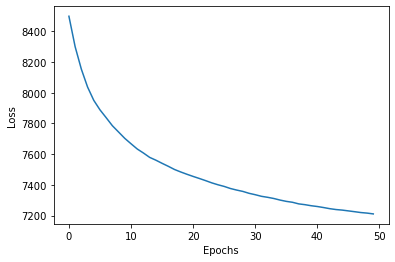

In [11]:
plt.plot(train_loss_epoch)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [13]:
PATH = "miwae.pt"

# Save
torch.save(vae.state_dict(), PATH)


In [9]:
vae.load_state_dict(torch.load("miwae.pt"))
vae.eval()

MIWAE(
  (encoder_h1): BasicBlock(
    (transform): Sequential(
      (0): Linear(in_features=784, out_features=200, bias=True)
      (1): Tanh()
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): Tanh()
    )
    (fc_mu): Linear(in_features=200, out_features=50, bias=True)
    (fc_logsigma): Linear(in_features=200, out_features=50, bias=True)
  )
  (decoder_x): Sequential(
    (0): Linear(in_features=50, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [10]:
# Reading some of the test data
for epoch in range(1):
    running_loss = [] 
    for idx, data in enumerate(test_data_loader):
        inputs = Variable(data[0])
        inputs = inputs.view(-1, 28 * 28)
        inputs = inputs.expand(5, 1000, 784)

In [11]:
# Removing Pixels while testing
def removeProbDataTest(tensorOG, p):
    image =tensorOG.numpy()
    nump = np.random.rand(image.shape[0])
    mask = (nump<(1-p))*1.0
    img_removed = mask*image
    
    return torch.from_numpy((mask==0)*1), torch.from_numpy(img_removed)

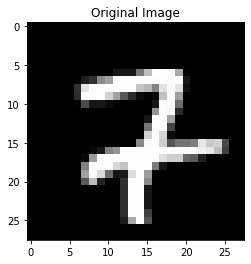

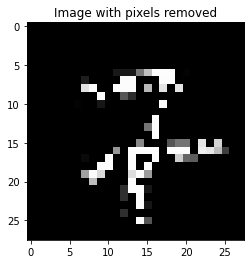

torch.Size([784])
torch.Size([])
torch.Size([5, 784])


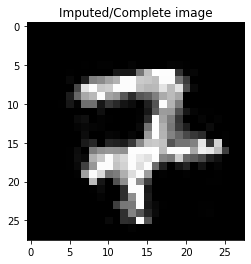

In [13]:
# Choose an image number
vae.eval()
number_chosen = 44

image_og = (inputs[0][number_chosen])
img_og = image_og.view(28, 28).data
plt.figure()
plt.imshow(img_og, cmap='gray')
plt.title('Original Image')
plt.show()

mask, image_og_removed = removeProbDataTest(inputs[0][number_chosen],0.5)
image_og_removed = image_og_removed.view(28, 28).data
mask= mask.view(28, 28).data

plt.figure()
plt.title('Image with pixels removed')
plt.imshow(image_og_removed, cmap='gray')
plt.show()

vae.float()
image_imputed = vae.impute(inputs[0][number_chosen])
image_imputed = image_imputed.view(28, 28).data
image_final = image_imputed*mask + image_og_removed
plt.figure()
plt.title('Imputed/Complete image')
plt.imshow(image_final,cmap='gray')
plt.show()

